In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news/FakeNewsNet.csv


In [2]:
!pip install torchtext==0.6
!pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import string
import random
import itertools

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import torchtext.data as data
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from tqdm import tqdm
import torch.nn.functional as F
from torchsummary import summary

from gensim.models import Word2Vec
import gensim

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras import initializers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
SEED = 42
random.seed(SEED)

BATCH_SIZE = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading data

In [5]:
df = pd.read_csv('/kaggle/input/fake-news/FakeNewsNet.csv')
df = df[['title','news_url','source_domain','real']]
df.head()

,title,news_url,source_domain,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1


In [6]:
df.shape

(23196, 4)

In [7]:
df.isna().sum()

title              0
news_url         330
source_domain    330
real               0
dtype: int64

In [8]:
df = df.dropna()
df.shape

(22866, 4)

In [9]:
print("Распределение классов:")
df['real'].value_counts()*100/df.shape[0]

Распределение классов:


real
1    75.968687
0    24.031313
Name: count, dtype: float64

In [10]:
df['text'] = df['title'] + " " + df['news_url'] + " " + df['source_domain']
df.head()

,title,news_url,source_domain,real,text
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1,Kandi Burruss Explodes Over Rape Accusation on...
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1,People's Choice Awards 2018: The best red carp...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1,Sophia Bush Sends Sweet Birthday Message to 'O...
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1,Colombian singer Maluma sparks rumours of inap...
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1,Gossip Girl 10 Years Later: How Upper East Sid...


## Preparation

In [11]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    tokens = [word for word in tokens if word.isalpha()]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

def preprocess_series(series):
    return series.apply(preprocess_text)

In [12]:
df['preprocessed_text'] = preprocess_series(df['text'])
df[['text', 'preprocessed_text']].head()

,text,preprocessed_text
0,Kandi Burruss Explodes Over Rape Accusation on...,kandi burruss explodes rape accusation real ho...
1,People's Choice Awards 2018: The best red carp...,peoples choice awards best red carpet looks ww...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,sophia bush sends sweet birthday message one t...
3,Colombian singer Maluma sparks rumours of inap...,colombian singer maluma sparks rumours inappro...
4,Gossip Girl 10 Years Later: How Upper East Sid...,gossip girl years later upper east siders shoc...


## Word2Vec

In [13]:
word2vec_model = Word2Vec(
    df['preprocessed_text'].apply(lambda x: x.split()),
    vector_size=100,
    min_count=1,
    window=5
)

vocab_size = len(word2vec_model.wv)
vocab_size

26715

## Tokenizing

In [14]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['preprocessed_text'])

In [15]:
df['tokenized_text'] = tokenizer.texts_to_sequences(df['preprocessed_text'])
df[['text', 'preprocessed_text', 'tokenized_text']].head()

,text,preprocessed_text,tokenized_text
0,Kandi Burruss Explodes Over Rape Accusation on...,kandi burruss explodes rape accusation real ho...,"[4637, 5211, 3830, 989, 5212, 76, 229, 960, 18..."
1,People's Choice Awards 2018: The best red carp...,peoples choice awards best red carpet looks ww...,"[853, 255, 15, 26, 78, 109, 161, 120]"
2,Sophia Bush Sends Sweet Birthday Message to 'O...,sophia bush sends sweet birthday message one t...,"[1525, 1067, 1711, 337, 64, 489, 99, 2841, 125..."
3,Colombian singer Maluma sparks rumours of inap...,colombian singer maluma sparks rumours inappro...,"[7078, 414, 3831, 1227, 1297, 2842, 68, 3832, 4]"
4,Gossip Girl 10 Years Later: How Upper East Sid...,gossip girl years later upper east siders shoc...,"[787, 203, 66, 1650, 1950, 1951, 11878, 1952, ..."


## Padding

In [16]:
maxlen = df['tokenized_text'].apply(len).max()
maxlen

36

In [17]:
padded_text = pad_sequences(df['tokenized_text'], maxlen=maxlen)
df['padded_text'] = np.split(padded_text, padded_text.shape[0])
df['padded_text'] = df['padded_text'].apply(lambda x: x[0])
df[['tokenized_text', 'padded_text']].head()

,tokenized_text,padded_text
0,"[4637, 5211, 3830, 989, 5212, 76, 229, 960, 18...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[853, 255, 15, 26, 78, 109, 161, 120]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1525, 1067, 1711, 337, 64, 489, 99, 2841, 125...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[7078, 414, 3831, 1227, 1297, 2842, 68, 3832, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[787, 203, 66, 1650, 1950, 1951, 11878, 1952, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
df[['tokenized_text', 'padded_text']].head().map(len)

,tokenized_text,padded_text
0,11,36
1,8,36
2,14,36
3,9,36
4,14,36


## Embedding matrix

In [19]:
embedding_matrix = np.zeros((vocab_size, word2vec_model.vector_size))
embedding_matrix[:3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

In [20]:
for word, i in tokenizer.word_index.items():
    if i >= tokenizer.num_words:
        continue
        
    embedding_vector = word2vec_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(26715, 100)

## PyTorch

### PyTorch. Split

In [19]:
def split_by_batchsize(arr, batch_size):
    return np.array_split(arr, (arr.shape[0]/batch_size)+1)
    
def create_batch_iterator(iter_df, batch_size, col):
    x = split_by_batchsize(df[col].to_numpy(), batch_size)
    n_batches = len(x)
    
    def iterator():
        for i in range(n_batches):
            yield np.array([*x[i]])
        return

    return iterator()

next(create_batch_iterator(df, BATCH_SIZE, 'padded_text'))

array([[    0,     0,     0, ...,   189,    32,   632],
       [    0,     0,     0, ...,   109,   161,   120],
       [    0,     0,     0, ...,  4639, 11877,    11],
       ...,
       [    0,     0,     0, ...,  5217,  5218,   824],
       [    0,     0,     0, ...,  1530,   234,     7],
       [    0,     0,     0, ...,   687,  2393,     1]], dtype=int32)

In [20]:
train, test = train_test_split(df[['padded_text', 'real']], test_size=0.2, random_state=42)
train.shape, test.shape

((18292, 2), (4574, 2))

### PyTorch. LSTM

In [23]:
embedding_matrix_tensor = torch.Tensor(embedding_matrix)
embedding_matrix_tensor

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-8.5843e-01,  1.1170e+00,  1.4693e-01,  ..., -1.4276e+00,
          1.2149e-01,  4.5955e-01],
        [-5.4189e-01,  9.0466e-01,  4.5023e-01,  ..., -1.1078e+00,
          1.5371e-01, -1.0209e-02],
        ...,
        [-1.1514e-02,  1.9784e-03,  2.3493e-03,  ..., -1.1192e-02,
          3.4924e-04,  8.7693e-03],
        [-1.5928e-04,  1.4134e-02,  2.5465e-03,  ..., -1.3758e-02,
         -7.3331e-03,  1.5495e-03],
        [-4.8173e-03,  1.5235e-03, -5.2234e-03,  ...,  9.2807e-03,
         -4.9983e-03,  1.6800e-02]])

In [38]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_tensor)
        self.embedding.requires_grad=False
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text).float())
        output, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden.squeeze(0))

INPUT_DIM = vocab_size
EMBEDDING_DIM = word2vec_model.vector_size
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5

model = LSTMModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)
model

LSTMModel(
  (embedding): Embedding(26715, 100)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [25]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [39]:
def train(model, df, x_col, y_col, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    all_predictions = []
    all_labels = []

    x_batches = create_batch_iterator(df, BATCH_SIZE, x_col)
    y_batches = create_batch_iterator(df, BATCH_SIZE, y_col)

    iterations = 0

    for batch_text, batch_label in zip(x_batches, y_batches):
        batch_text = torch.Tensor(batch_text).to(device).long().T
        batch_label = torch.Tensor(batch_label).to(device).long()
        # print(batch_text.shape, batch_label.shape)
        
        optimizer.zero_grad()
        predictions = model(batch_text).squeeze(1)
        # print(predictions.shape, batch_label.shape)
        loss = criterion(predictions.float(), batch_label.float())
        acc = binary_accuracy(predictions, batch_label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions += predictions.tolist()
        all_labels += batch_label.tolist()

        iterations += 1
    
    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)
    val_acc = binary_accuracy(all_predictions, all_labels)
    val_loss = criterion(all_predictions.float(), all_labels.float()).item()

    return epoch_loss / iterations, epoch_acc / iterations, val_loss, val_acc.item()

In [30]:
N_EPOCHS = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, val_loss, val_acc = train(model, train, 'padded_text', 'real', optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

 10%|█         | 1/10 [00:05<00:45,  5.01s/it]

Epoch: 01, Train Loss: 0.483, Train Acc: 79.47%, Val Loss: 0.483, Val Acc: 79.47%


 20%|██        | 2/10 [00:09<00:36,  4.58s/it]

Epoch: 02, Train Loss: 0.454, Train Acc: 80.84%, Val Loss: 0.454, Val Acc: 80.84%


 30%|███       | 3/10 [00:13<00:31,  4.44s/it]

Epoch: 03, Train Loss: 0.449, Train Acc: 81.35%, Val Loss: 0.449, Val Acc: 81.35%


 40%|████      | 4/10 [00:17<00:26,  4.39s/it]

Epoch: 04, Train Loss: 0.441, Train Acc: 81.66%, Val Loss: 0.441, Val Acc: 81.66%


 50%|█████     | 5/10 [00:22<00:21,  4.38s/it]

Epoch: 05, Train Loss: 0.437, Train Acc: 82.03%, Val Loss: 0.437, Val Acc: 82.03%


 60%|██████    | 6/10 [00:26<00:17,  4.36s/it]

Epoch: 06, Train Loss: 0.434, Train Acc: 82.02%, Val Loss: 0.434, Val Acc: 82.02%


 70%|███████   | 7/10 [00:30<00:13,  4.35s/it]

Epoch: 07, Train Loss: 0.431, Train Acc: 82.23%, Val Loss: 0.431, Val Acc: 82.23%


 80%|████████  | 8/10 [00:35<00:08,  4.32s/it]

Epoch: 08, Train Loss: 0.426, Train Acc: 82.53%, Val Loss: 0.426, Val Acc: 82.53%


 90%|█████████ | 9/10 [00:39<00:04,  4.31s/it]

Epoch: 09, Train Loss: 0.425, Train Acc: 82.44%, Val Loss: 0.425, Val Acc: 82.44%


100%|██████████| 10/10 [00:43<00:00,  4.37s/it]

Epoch: 10, Train Loss: 0.420, Train Acc: 82.57%, Val Loss: 0.420, Val Acc: 82.57%


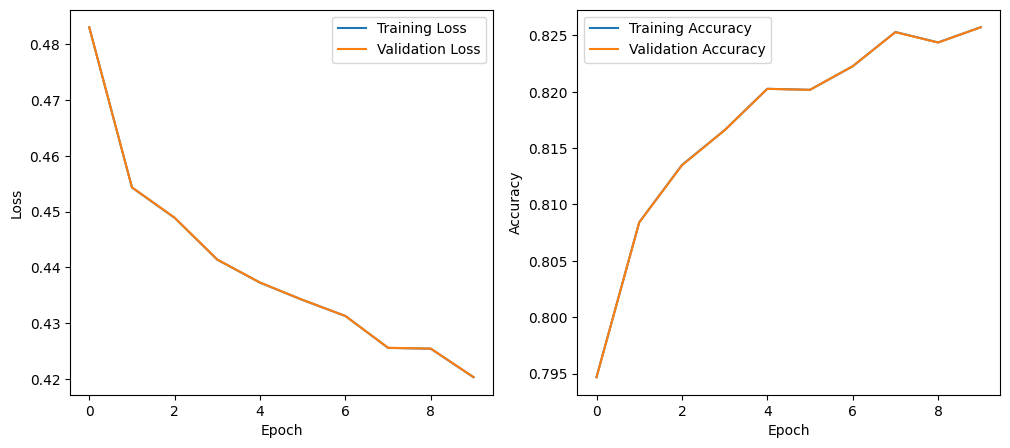

In [31]:
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
def evaluate_model(model, df, x_col, y_col):
    all_predictions = []
    all_labels = []

    x_batches = create_batch_iterator(df, BATCH_SIZE, x_col)
    y_batches = create_batch_iterator(df, BATCH_SIZE, y_col)

    for batch_text, batch_label in zip(x_batches, y_batches):
        batch_text = torch.Tensor(batch_text).to(device).long().T
        batch_label = torch.Tensor(batch_label).to(device).long()
        
        predictions = model(batch_text).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += batch_label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    fpr, tpr, _ = roc_curve(y_true, all_predictions.cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.8305344179130587
F1 Score: 0.8956790954368017
ROC AUC Score: 0.8060541533013224


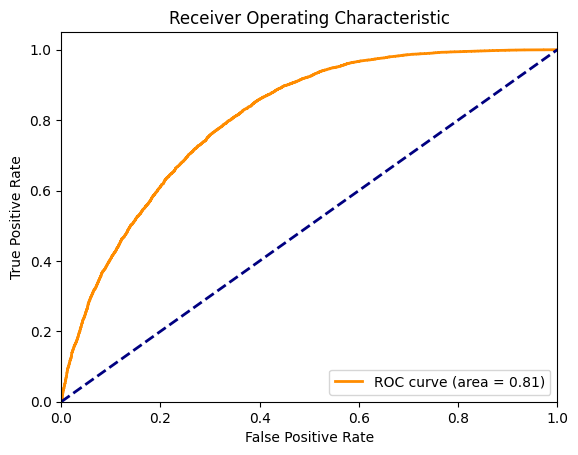

In [33]:
evaluate_model(model, test, 'padded_text', 'real')

### PyTorch. RNN

In [40]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_tensor)
        self.embedding.requires_grad=False
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout = dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text).float())
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden.squeeze(0))

INPUT_DIM = vocab_size
EMBEDDING_DIM = word2vec_model.vector_size
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5

model = RNNModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)
model

RNNModel(
  (embedding): Embedding(26715, 100)
  (rnn): RNN(100, 256, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [41]:
N_EPOCHS = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, val_loss, val_acc = train(model, train, 'padded_text', 'real', optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

 10%|█         | 1/10 [00:02<00:20,  2.28s/it]

Epoch: 01, Train Loss: 0.504, Train Acc: 78.63%, Val Loss: 0.504, Val Acc: 78.63%


 20%|██        | 2/10 [00:04<00:17,  2.16s/it]

Epoch: 02, Train Loss: 0.499, Train Acc: 78.62%, Val Loss: 0.499, Val Acc: 78.62%


 30%|███       | 3/10 [00:06<00:14,  2.13s/it]

Epoch: 03, Train Loss: 0.490, Train Acc: 79.23%, Val Loss: 0.490, Val Acc: 79.23%


 40%|████      | 4/10 [00:08<00:12,  2.10s/it]

Epoch: 04, Train Loss: 0.485, Train Acc: 79.31%, Val Loss: 0.485, Val Acc: 79.31%


 50%|█████     | 5/10 [00:10<00:10,  2.08s/it]

Epoch: 05, Train Loss: 0.485, Train Acc: 79.50%, Val Loss: 0.485, Val Acc: 79.50%


 60%|██████    | 6/10 [00:12<00:08,  2.08s/it]

Epoch: 06, Train Loss: 0.483, Train Acc: 79.18%, Val Loss: 0.483, Val Acc: 79.18%


 70%|███████   | 7/10 [00:14<00:06,  2.15s/it]

Epoch: 07, Train Loss: 0.482, Train Acc: 79.62%, Val Loss: 0.482, Val Acc: 79.62%


 80%|████████  | 8/10 [00:17<00:04,  2.14s/it]

Epoch: 08, Train Loss: 0.483, Train Acc: 79.61%, Val Loss: 0.483, Val Acc: 79.61%


 90%|█████████ | 9/10 [00:19<00:02,  2.11s/it]

Epoch: 09, Train Loss: 0.477, Train Acc: 79.98%, Val Loss: 0.477, Val Acc: 79.97%


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]

Epoch: 10, Train Loss: 0.477, Train Acc: 80.02%, Val Loss: 0.477, Val Acc: 80.02%


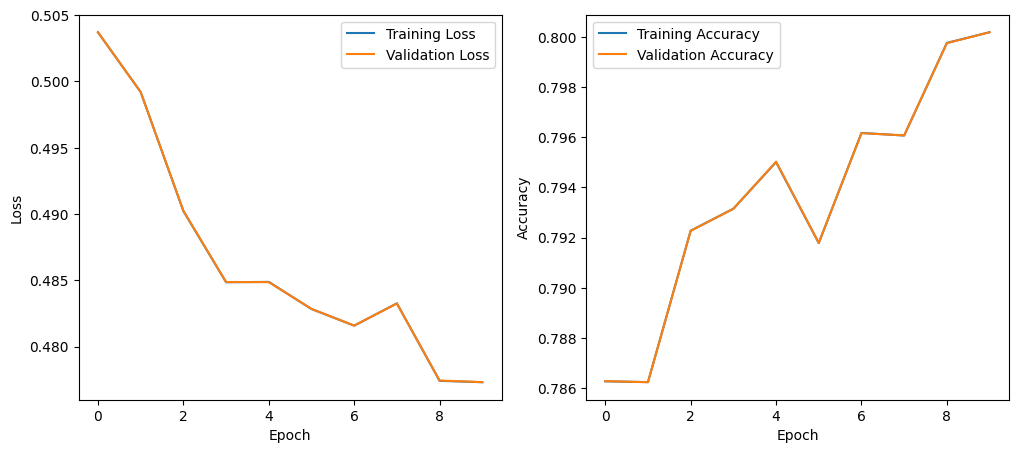

In [42]:
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Accuracy: 0.8018455348552436
F1 Score: 0.8790862754516586
ROC AUC Score: 0.7402824795218663


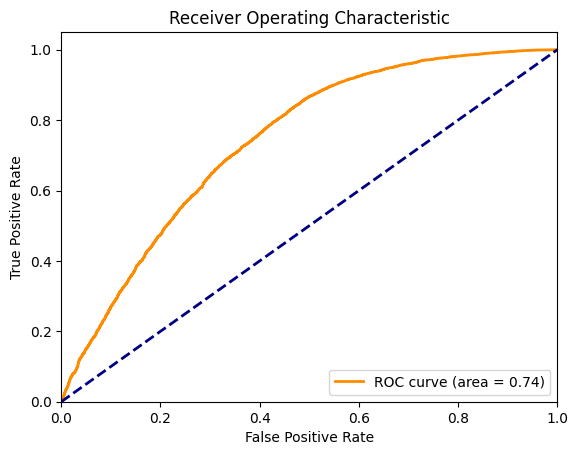

In [43]:
evaluate_model(model, test, 'padded_text', 'real')

### PyTorch. GRU

In [46]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_tensor)
        self.embedding.requires_grad=False
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout = dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text).float())
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden.squeeze(0))

INPUT_DIM = vocab_size
EMBEDDING_DIM = word2vec_model.vector_size
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5

model = GRUModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)
model

GRUModel(
  (embedding): Embedding(26715, 100)
  (rnn): GRU(100, 256, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

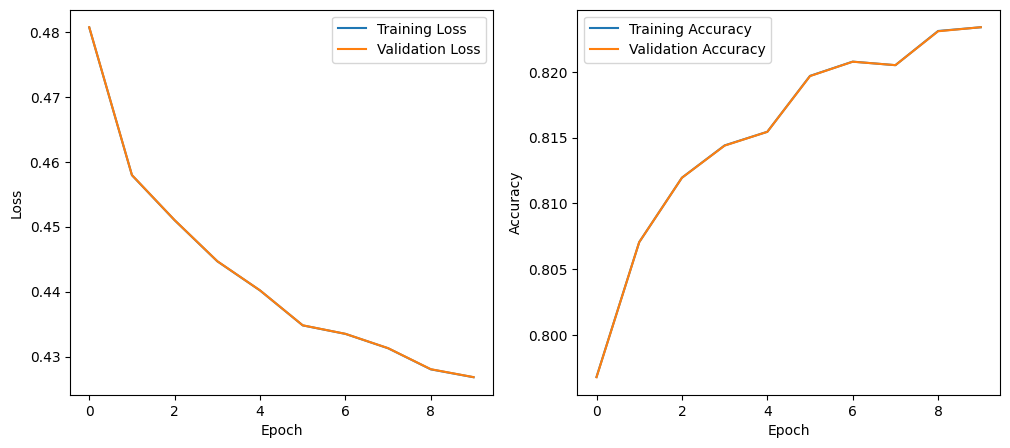

In [49]:
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [47]:
N_EPOCHS = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, val_loss, val_acc = train(model, train, 'padded_text', 'real', optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

 10%|█         | 1/10 [00:04<00:37,  4.17s/it]

Epoch: 01, Train Loss: 0.481, Train Acc: 79.68%, Val Loss: 0.481, Val Acc: 79.68%


 20%|██        | 2/10 [00:08<00:33,  4.17s/it]

Epoch: 02, Train Loss: 0.458, Train Acc: 80.71%, Val Loss: 0.458, Val Acc: 80.70%


 30%|███       | 3/10 [00:12<00:28,  4.13s/it]

Epoch: 03, Train Loss: 0.451, Train Acc: 81.20%, Val Loss: 0.451, Val Acc: 81.19%


 40%|████      | 4/10 [00:16<00:24,  4.12s/it]

Epoch: 04, Train Loss: 0.445, Train Acc: 81.44%, Val Loss: 0.445, Val Acc: 81.44%


 50%|█████     | 5/10 [00:20<00:20,  4.10s/it]

Epoch: 05, Train Loss: 0.440, Train Acc: 81.54%, Val Loss: 0.440, Val Acc: 81.54%


 60%|██████    | 6/10 [00:24<00:16,  4.08s/it]

Epoch: 06, Train Loss: 0.435, Train Acc: 81.97%, Val Loss: 0.435, Val Acc: 81.97%


 70%|███████   | 7/10 [00:28<00:12,  4.09s/it]

Epoch: 07, Train Loss: 0.433, Train Acc: 82.08%, Val Loss: 0.433, Val Acc: 82.08%


 80%|████████  | 8/10 [00:33<00:08,  4.18s/it]

Epoch: 08, Train Loss: 0.431, Train Acc: 82.05%, Val Loss: 0.431, Val Acc: 82.05%


 90%|█████████ | 9/10 [00:37<00:04,  4.16s/it]

Epoch: 09, Train Loss: 0.428, Train Acc: 82.31%, Val Loss: 0.428, Val Acc: 82.31%


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]

Epoch: 10, Train Loss: 0.427, Train Acc: 82.34%, Val Loss: 0.427, Val Acc: 82.34%


Accuracy: 0.8270795066911572
F1 Score: 0.8948683860675352
ROC AUC Score: 0.8059588400212481


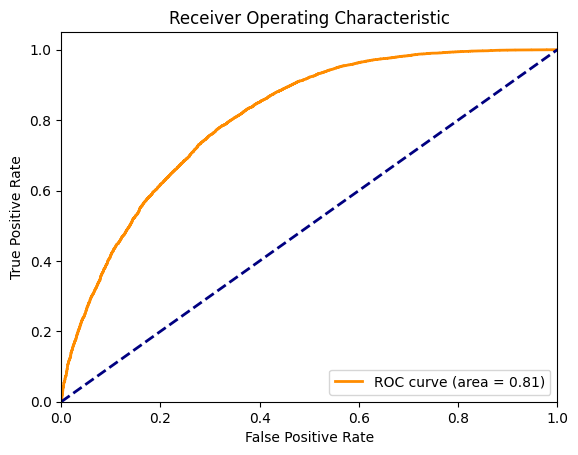

In [48]:
evaluate_model(model, test, 'padded_text', 'real')

## Tensor Flow

### Tensor Flow. Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df[['padded_text']], df['real'], test_size=0.20, random_state=42)

X_train = tf.convert_to_tensor(np.stack(X_train['padded_text'].to_numpy()))
X_test = tf.convert_to_tensor(np.stack(X_test['padded_text'].to_numpy()))

y_train = tf.convert_to_tensor(np.stack(y_train.to_numpy()))
y_test = tf.convert_to_tensor(np.stack(y_test.to_numpy()))

### Tensor Flow. RNN

In [48]:
from tensorflow.keras.regularizers import l2

In [55]:
N_EPOCHS = 50

embedding_layer = Embedding(
    input_dim = vocab_size,
    output_dim = word2vec_model.vector_size,
    embeddings_initializer = initializers.Constant(embedding_matrix),
    trainable = False
)

model_RNN = Sequential()
model_RNN.add(embedding_layer)
# model_RNN.add(SimpleRNN(units=64))
model_RNN.add(SimpleRNN(units=64, return_sequences=True))
# model_RNN.add(SimpleRNN(units=128))
model_RNN.add(Dropout(0.2))
model_RNN.add(SimpleRNN(units=32))
# model_RNN.add(Dense(units=64))
model_RNN.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.01)))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model_RNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_RNN.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = model_RNN.fit(
    X_train, 
    y_train, 
    epochs=N_EPOCHS, 
    validation_split=0.2, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    callbacks=[early_stop]
)

Epoch 1/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7644 - loss: 0.5445 - val_accuracy: 0.7994 - val_loss: 0.4825
Epoch 2/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7942 - loss: 0.4892 - val_accuracy: 0.8043 - val_loss: 0.4719
Epoch 3/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8118 - loss: 0.4601 - val_accuracy: 0.8038 - val_loss: 0.4654
Epoch 4/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8121 - loss: 0.4571 - val_accuracy: 0.8092 - val_loss: 0.4660
Epoch 5/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8225 - loss: 0.4432 - val_accuracy: 0.8060 - val_loss: 0.4608
Epoch 6/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8199 - loss: 0.4395 - val_accuracy: 0.8120 - val_loss: 0.4534
Epoch 7/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8278 - loss: 0.4304 - val_accuracy: 0.8090 - val_loss: 0.4613
Epoch 8/50
488/488 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8169 - loss: 0.4453 - val_acc

In [52]:
def acc_loss_plot(history):
    
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = history.epoch
    
    plt.figure(figsize=(6,4))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss', size=10)
    plt.xlabel('Epochs', size=10)
    plt.ylabel('Loss', size=10)
    plt.legend(prop={'size': 10})
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy', size=10)
    plt.xlabel('Epochs', size=10)
    plt.ylabel('Accuracy', size=10)
    plt.legend(prop={'size': 10})
    plt.ylim((0.5,1))
    plt.show()


def scores_and_roc_curve(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    y_pred_binary = np.round(y_pred)
    
    accuracy = accuracy_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

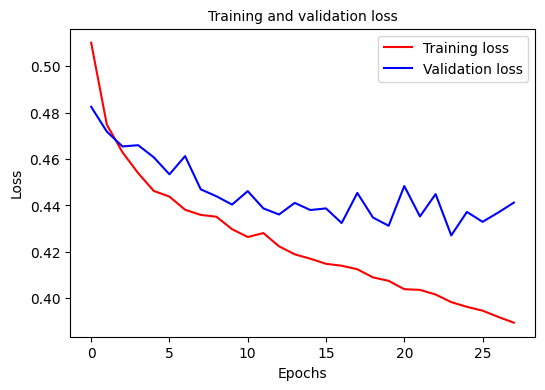

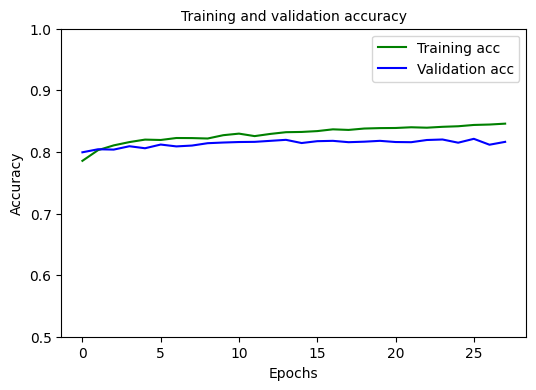

In [57]:
acc_loss_plot(history)

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.8255356362046349
F1 Score: 0.8925397252895233
ROC AUC Score: 0.8104804154182683


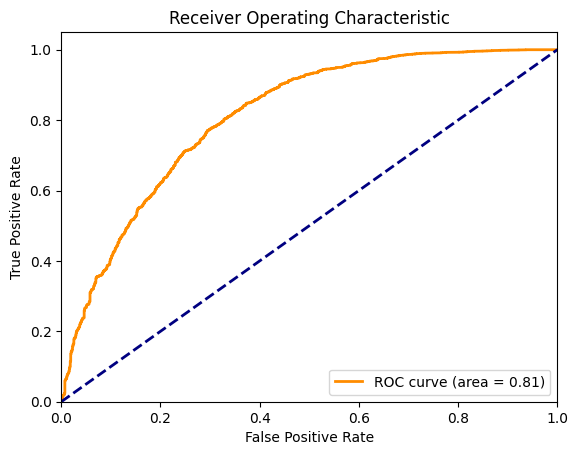

In [58]:
scores_and_roc_curve(model_RNN, X_test, y_test)

### Tensor Flow. LSTM

In [107]:
N_EPOCHS = 10

embedding_layer = Embedding(
    input_dim = vocab_size,
    output_dim = word2vec_model.vector_size,
    embeddings_initializer = initializers.Constant(embedding_matrix),
    trainable = False
)

model_LSTM = Sequential()
model_LSTM.add(embedding_layer)
model_LSTM.add(LSTM(units=64))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(units=1, activation='sigmoid'))

model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [108]:
history = model_LSTM.fit(X_train, y_train, epochs=N_EPOCHS, validation_split=0.2, batch_size=BATCH_SIZE)

Epoch 1/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7793 - loss: 0.5034 - val_accuracy: 0.8057 - val_loss: 0.4522
Epoch 2/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8080 - loss: 0.4556 - val_accuracy: 0.8109 - val_loss: 0.4461
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8198 - loss: 0.4370 - val_accuracy: 0.8131 - val_loss: 0.4394
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8227 - loss: 0.4342 - val_accuracy: 0.8183 - val_loss: 0.4323
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8212 - loss: 0.4330 - val_accuracy: 0.8185 - val_loss: 0.4302
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8267 - loss: 0.4200 - val_accuracy: 0.8185 - val_loss: 0.4316
Epoch 7/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8306 - loss: 0.4156 - val_accuracy: 0.8177 - val_loss: 0.4316
Epoch 8/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8325 - loss: 0.4143 - 

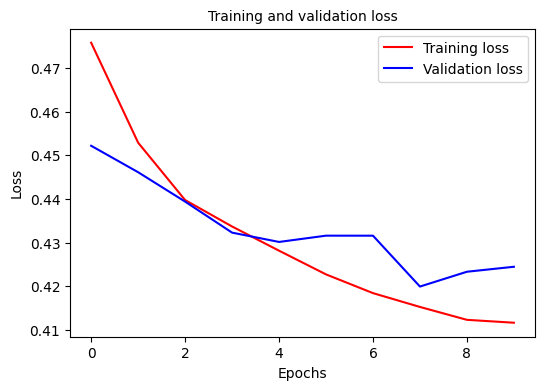

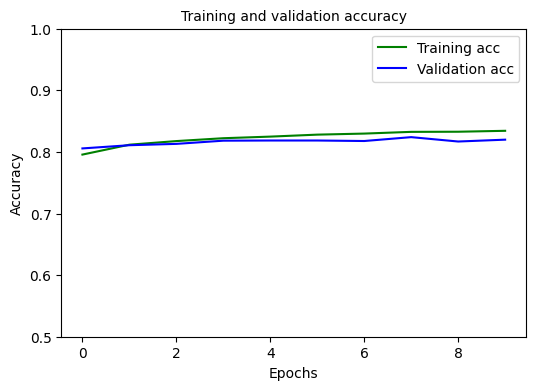

In [109]:
acc_loss_plot(history)

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Accuracy: 0.8268473983384347
F1 Score: 0.8915068493150684
ROC AUC Score: 0.8178793685245791


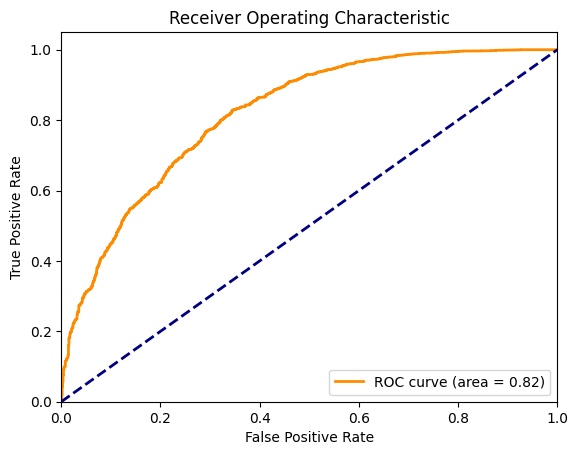

In [110]:
scores_and_roc_curve(model_LSTM, X_test, y_test)

### Tensor Flow. GRU

In [23]:
N_EPOCHS = 10

embedding_layer = Embedding(
    input_dim = vocab_size,
    output_dim = word2vec_model.vector_size,
    embeddings_initializer = initializers.Constant(embedding_matrix),
    trainable = False
)

model_GRU = Sequential()
model_GRU.add(embedding_layer)
model_GRU.add(GRU(units=64))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(units=1, activation='sigmoid'))

model_GRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_GRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model_GRU.fit(X_train, y_train, epochs=N_EPOCHS, validation_split=0.2, batch_size=BATCH_SIZE)

Epoch 1/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.7730 - loss: 0.5086 - val_accuracy: 0.8002 - val_loss: 0.4630
Epoch 2/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8160 - loss: 0.4469 - val_accuracy: 0.8114 - val_loss: 0.4455
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8214 - loss: 0.4359 - val_accuracy: 0.8144 - val_loss: 0.4378
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8231 - loss: 0.4311 - val_accuracy: 0.8199 - val_loss: 0.4352
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8231 - loss: 0.4288 - val_accuracy: 0.8163 - val_loss: 0.4342
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8311 - loss: 0.4186 - val_accuracy: 0.8177 - val_loss: 0.4304
Epoch 7/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8316 - loss: 0.4170 - val_accuracy: 0.8180 - val_loss: 0.4325
Epoch 8/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8294 - loss: 0.4220 - 

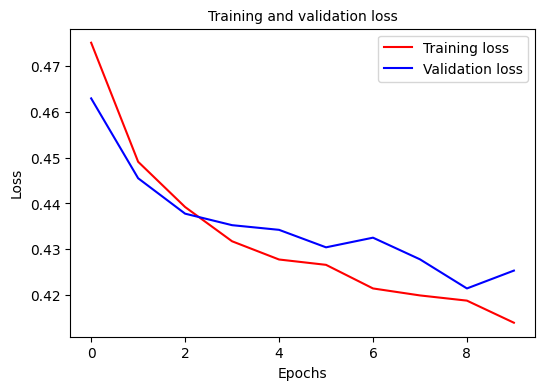

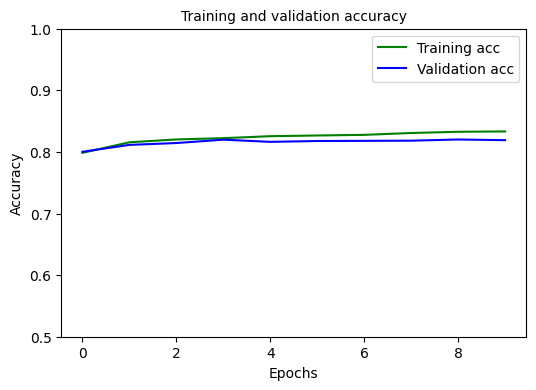

In [27]:
acc_loss_plot(history)

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy: 0.8244425010931351
F1 Score: 0.8941331575477917
ROC AUC Score: 0.8153972678500853


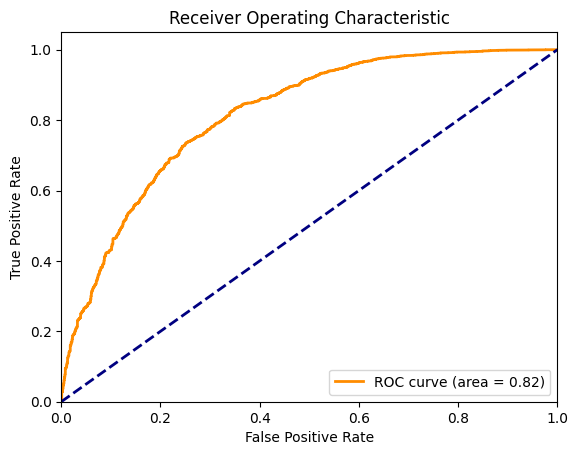

In [28]:
scores_and_roc_curve(model_GRU, X_test, y_test)